# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
#from keras.models import load_model
#from keras.models import model_from_json

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools
import time

In [2]:
# To determine % of files that contain teh hero:
# (From: https://udacity-robotics.slack.com/files/U4UKR0C5Q/F7DTF3D1C/Script_to_see_what___of_training_image_masks_contain_the_hero.py)
#By tokyo_adam 4-10-17 
import cv2
import numpy as np
import glob, os

#set to the directory where your masks are saved
print ("Current dir: ", os.getcwd())
img_dir = "../data/masks/train/set0"

total_files = 0
total_hero = 0

#os.chdir(img_dir)
files = glob.glob(os.path.join(img_dir, 'masks', "*.png"))
print ("Files found: ", len(files))
if (len(files) > 0):
    for file in files:
        total_files +=1

        img = cv2.imread(file)
        blue = img[:,:,0]

        if np.any(blue == 255):
            total_hero += 1
    percent_hero = 100. * total_hero / total_files
    print (percent_hero, "percent of files containing the hero")
else:
    print ("No files found in folder: ", img_dir)

Current dir:  /home/ubuntu/projects/RoboND-FollowMe/code
Files found:  4131
37.64221738077947 percent of files containing the hero


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, kernel_size, strides, name="sep-convolution-w-batchnorm"):
    with tf.name_scope(name):
        output_layer = SeparableConv2DKeras(filters=filters,kernel_size=kernel_size, strides=strides,
                                            padding='same', activation='relu'
                                            #, name='separable-conv-layer'
                                            )(input_layer)

        output_layer = layers.BatchNormalization(
                                                #name="batch-normalization-layer"
                                                )(output_layer)
        return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size, strides, name="convolution-w-batchnorm"):
    with tf.name_scope(name):
        output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                                     padding='same', activation='relu'
                                     #, name='convolution-layer'
                                    )(input_layer)

        output_layer = layers.BatchNormalization(
                                                #name="batch-normalization-layer"
                                                )(output_layer)
        return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer, multiplier, name="bi-upsample"):
    with tf.name_scope(name):
        output_layer = BilinearUpSampling2D((multiplier, multiplier)
                                            #, name="upsampler-layer"
                                           )(input_layer)
#         tf.summary.histogram('weights', output_layer.get_weights()[0])
#         tf.summary.histogram('biases', output_layer.get_weights()[1])
#         tf.summary.histogram('biases', output_layer.output)
        return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, kernel_size, strides, name="encoder-block"):
    with tf.name_scope(name):
        # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
        output_layer = separable_conv2d_batchnorm(input_layer, filters, kernel_size=kernel_size, strides=strides, name="separable-convolution-block")
        return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters, multiplier, kernel_size, name="decoder-block"):
    
    with tf.name_scope(name):
        # TODO Upsample the small input layer using the bilinear_upsample() function.
        upsampled_layer = bilinear_upsample(small_ip_layer, multiplier=multiplier, name='upsample-block')

        # TODO Concatenate the upsampled and large input layers using layers.concatenate
        layer = layers.concatenate([upsampled_layer, large_ip_layer]
                                   #, name='concatenate-1'
                                  )
        print ("Concatenating: {} + {} = {}".format(upsampled_layer.get_shape(), large_ip_layer.get_shape(), layer.get_shape()))

        # TODO Add some number of separable convolution layers
        layer = separable_conv2d_batchnorm(layer, filters, kernel_size=kernel_size, strides=1
                                           #, name="separable-convolution-block-1"
                                          )
        layer = separable_conv2d_batchnorm(layer, filters, kernel_size=kernel_size, strides=1
                                           #, name="separable-convolution-block-2"
                                          )

        return layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    
    print("Input: {}".format(inputs.get_shape()))
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    with tf.name_scope("model"):
        layer = conv_1 = encoder_block(inputs, filters=32, kernel_size=3, strides=2, name='encoder-block-1')
        print("Conv1: {}".format(layer.get_shape()))
        layer = conv_2 = encoder_block(layer, filters=64, kernel_size=3, strides=2, name='encoder-block-2')
        print("Conv2: {}".format(layer.get_shape()))
        layer = conv_3 = encoder_block(layer, filters=128, kernel_size=3, strides=2, name='encoder-block-3')
        print("Conv3: {}".format(layer.get_shape()))
        layer = conv_4 = encoder_block(layer, filters=256, kernel_size=3, strides=2, name='encoder-block-4')
        print("Conv4: {}".format(layer.get_shape()))
        layer = conv_5 = encoder_block(layer, filters=512, kernel_size=3, strides=2, name='encoder-block-5')
        print("Conv5: {}".format(layer.get_shape()))

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
        layer = conv_6 = conv2d_batchnorm(layer, filters=512, kernel_size=1, strides=1, name='1x1-convolution')
        print("1x1: {}".format(layer.get_shape()))
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
        layer = conv_7 = decoder_block(layer, conv_4, filters=256, multiplier=2, kernel_size=3, name='decoder-block-5')
        print("Conv7: {}".format(layer.get_shape()))
        layer = conv_8 = decoder_block(layer, conv_3, filters=128, multiplier=2, kernel_size=3, name='decoder-block-4')
        print("Conv8: {}".format(layer.get_shape()))
        layer = conv_9 = decoder_block(layer, conv_2, filters=64, multiplier=2, kernel_size=3, name='decoder-block-3')
        print("Conv9: {}".format(layer.get_shape()))
        layer = conv_10 = decoder_block(layer, conv_1, filters=32, multiplier=2, kernel_size=3, name='decoder-block-2')
        print("Conv10: {}".format(layer.get_shape()))
        layer = conv_11 = decoder_block(layer, inputs, filters=16, multiplier=2, kernel_size=3, name='decoder-block-1')
        print("Conv11: {}".format(layer.get_shape()))
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
        layer = output_layer = layers.Conv2D(filters=num_classes, kernel_size=3, strides=1, activation='softmax', padding='same', name='output-layer')(layer)
#         tf.summary.histogram('weights', output_layer.get_weights()[0])
#         tf.summary.histogram('biases', output_layer.get_weights()[1])
#         tf.summary.histogram('biases', output_layer.output)
        print ("Output: {}".format(layer.get_shape()))
        return output_layer

### Data Augmentation
This section defines two data augmentation methods:
- do_filter(): To filter out image+mask tuples that do not satisfy a criteria. A 'True' return value drops the item from consideration. 'False' retains the tuple.
- do_preprocess(): To perform any modification to the image and/or mask, such as vertical flip, etc.

In [8]:
# To filter out any image files that do not satisfy certain criteria (DURING TRAINING ONLY)
def do_filter(image_path, mask_path):
    contains_hero = misc.imread(mask_path)[:,:,0].max() == 255
    if not contains_hero:
        r = random.uniform(0, 1)
        if r > 0.30:
            return False # We process only 70% of images without the hero
        else:
            return True

    # If hero exists, we always accept by returning False
    return False

# To modify the image and mask before they are used for training (DURING TRAINING ONLY)
import random
import cv2

def do_preprocess(image, mask):
    r = random.uniform(0, 1)
    if r > 0.50:
#        print ("x", end="")
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)
#    else:
#        print (".", end="")
    return image, mask

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **batches_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **batches_per_validation**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except batches_per_validation is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [9]:
# This class is tracked at each training invocation
# Any data point that affects the training outcome should go here
class T (object):
    # Static
    image_hw = 160
    image_shape = (image_hw, image_hw, 3)
    num_classes = 3
    
    # Changing
    learning_rate = 0.001
    batch_size = 32 # 200,
    num_epochs = 200
    batches_per_epoch = 130 #200
    batches_per_validation = 25 # 50
    workers = 1
    train_set_names = ['set0']
    validation_set_names = ['set0']
    weights_file_name = 'weights.hd5'
    arch_file_name = 'architecture.json'
    reload_weights = False
    skip_training = False
    dry_run = False
    patience = 25

#class Trackables(object):
#  def __init__(self, adict):
#    self.__dict__.update(adict)


## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Defining the input and output layers:
inputs = layers.Input(T.image_shape)
output_layer = fcn_model(inputs, T.num_classes)

Input: (?, 160, 160, 3)
Conv1: (?, 80, 80, 32)
Conv2: (?, 40, 40, 64)
Conv3: (?, 20, 20, 128)
Conv4: (?, 10, 10, 256)
Conv5: (?, 5, 5, 512)
1x1: (?, 5, 5, 512)
Concatenating: (?, 10, 10, 512) + (?, 10, 10, 256) = (?, 10, 10, 768)
Conv7: (?, 10, 10, 256)
Concatenating: (?, 20, 20, 256) + (?, 20, 20, 128) = (?, 20, 20, 384)
Conv8: (?, 20, 20, 128)
Concatenating: (?, 40, 40, 128) + (?, 40, 40, 64) = (?, 40, 40, 192)
Conv9: (?, 40, 40, 64)
Concatenating: (?, 80, 80, 64) + (?, 80, 80, 32) = (?, 80, 80, 96)
Conv10: (?, 80, 80, 32)
Concatenating: (?, 160, 160, 32) + (?, 160, 160, 3) = (?, 160, 160, 35)
Conv11: (?, 160, 160, 16)
Output: (?, 160, 160, 3)


Building model from a clean slate...
Training data: ['../data/masks/train/set0']
Initializing the batch iterator...
Read 4131 image files.
Initializing the batch iterator...
Read 1184 image files.
Epoch 1/200
129/130 [============================>.] - ETA: 0s - loss: 0.5839Epoch 00000: saving model to ../data/weights/history/18_01_2018_13_38_27/00-weights-val_loss(0.1409).h5


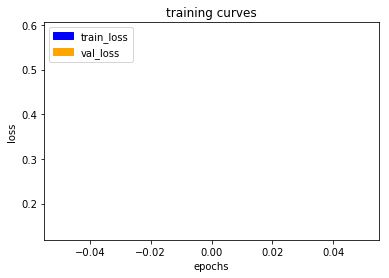

Epoch 00000: val_loss improved from inf to 0.14086, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 64s - loss: 0.5805 - val_loss: 0.1409
Epoch 2/200
129/130 [============================>.] - ETA: 0s - loss: 0.0811Epoch 00001: saving model to ../data/weights/history/18_01_2018_13_38_27/01-weights-val_loss(0.1064).h5


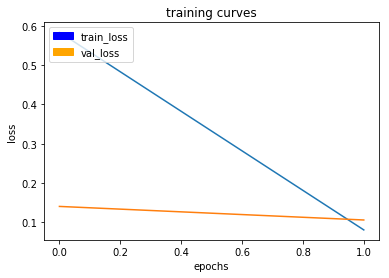

Epoch 00001: val_loss improved from 0.14086 to 0.10638, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0816 - val_loss: 0.1064
Epoch 3/200
129/130 [============================>.] - ETA: 0s - loss: 0.0521Epoch 00002: saving model to ../data/weights/history/18_01_2018_13_38_27/02-weights-val_loss(0.0975).h5


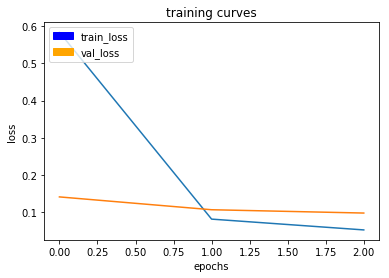

Epoch 00002: val_loss improved from 0.10638 to 0.09746, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0522 - val_loss: 0.0975
Epoch 4/200
129/130 [============================>.] - ETA: 0s - loss: 0.0418Epoch 00003: saving model to ../data/weights/history/18_01_2018_13_38_27/03-weights-val_loss(0.0875).h5


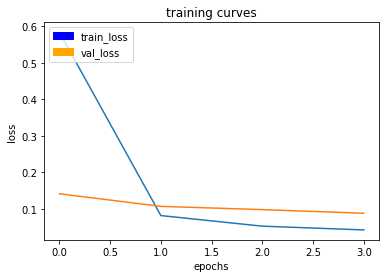

Epoch 00003: val_loss improved from 0.09746 to 0.08749, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0426 - val_loss: 0.0875
Epoch 5/200
129/130 [============================>.] - ETA: 0s - loss: 0.0484Epoch 00004: saving model to ../data/weights/history/18_01_2018_13_38_27/04-weights-val_loss(0.0463).h5


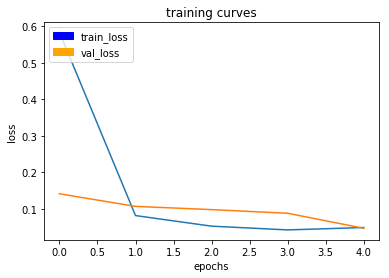

Epoch 00004: val_loss improved from 0.08749 to 0.04628, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0487 - val_loss: 0.0463
Epoch 6/200
129/130 [============================>.] - ETA: 0s - loss: 0.0367Epoch 00005: saving model to ../data/weights/history/18_01_2018_13_38_27/05-weights-val_loss(0.0486).h5


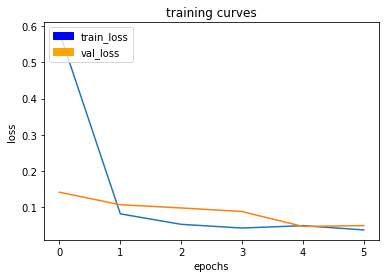

Epoch 00005: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0366 - val_loss: 0.0486
Epoch 7/200
129/130 [============================>.] - ETA: 0s - loss: 0.0321Epoch 00006: saving model to ../data/weights/history/18_01_2018_13_38_27/06-weights-val_loss(0.0401).h5


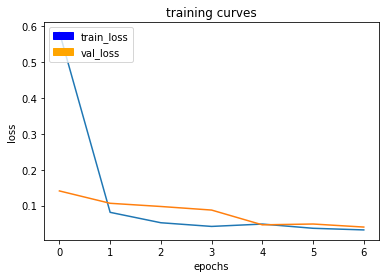

Epoch 00006: val_loss improved from 0.04628 to 0.04007, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0321 - val_loss: 0.0401
Epoch 8/200
129/130 [============================>.] - ETA: 0s - loss: 0.0295Epoch 00007: saving model to ../data/weights/history/18_01_2018_13_38_27/07-weights-val_loss(0.0453).h5


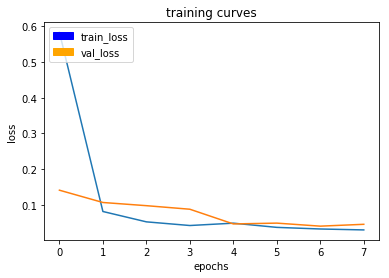

Epoch 00007: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0294 - val_loss: 0.0453
Epoch 9/200
129/130 [============================>.] - ETA: 0s - loss: 0.0277Epoch 00008: saving model to ../data/weights/history/18_01_2018_13_38_27/08-weights-val_loss(0.0422).h5


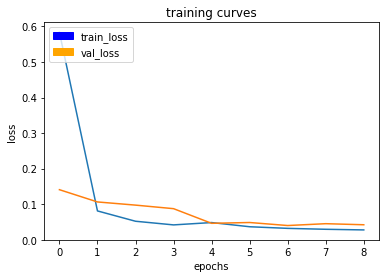

Epoch 00008: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0278 - val_loss: 0.0422
Epoch 10/200
129/130 [============================>.] - ETA: 0s - loss: 0.0273Epoch 00009: saving model to ../data/weights/history/18_01_2018_13_38_27/09-weights-val_loss(0.0346).h5


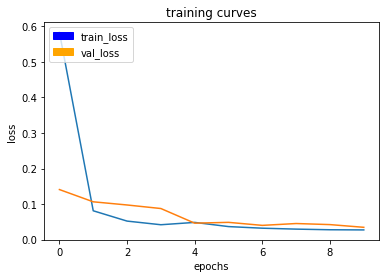

Epoch 00009: val_loss improved from 0.04007 to 0.03460, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0273 - val_loss: 0.0346
Epoch 11/200
129/130 [============================>.] - ETA: 0s - loss: 0.0283Epoch 00010: saving model to ../data/weights/history/18_01_2018_13_38_27/10-weights-val_loss(0.6511).h5


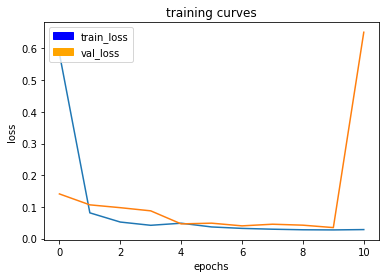

Epoch 00010: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0285 - val_loss: 0.6511
Epoch 12/200
129/130 [============================>.] - ETA: 0s - loss: 0.0257Epoch 00011: saving model to ../data/weights/history/18_01_2018_13_38_27/11-weights-val_loss(0.0294).h5


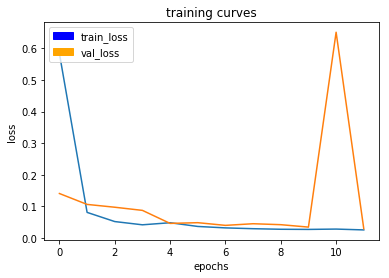

Epoch 00011: val_loss improved from 0.03460 to 0.02943, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0257 - val_loss: 0.0294
Epoch 13/200
129/130 [============================>.] - ETA: 0s - loss: 0.0235Epoch 00012: saving model to ../data/weights/history/18_01_2018_13_38_27/12-weights-val_loss(0.0761).h5


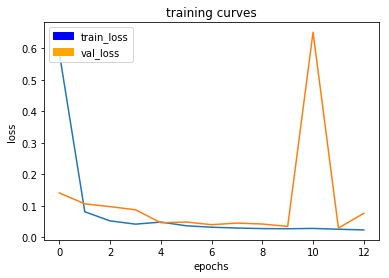

Epoch 00012: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0240 - val_loss: 0.0761
Epoch 14/200
129/130 [============================>.] - ETA: 0s - loss: 0.0239Epoch 00013: saving model to ../data/weights/history/18_01_2018_13_38_27/13-weights-val_loss(0.0405).h5


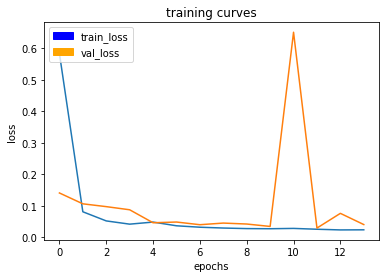

Epoch 00013: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0238 - val_loss: 0.0405
Epoch 15/200
129/130 [============================>.] - ETA: 0s - loss: 0.0244Epoch 00014: saving model to ../data/weights/history/18_01_2018_13_38_27/14-weights-val_loss(0.0892).h5


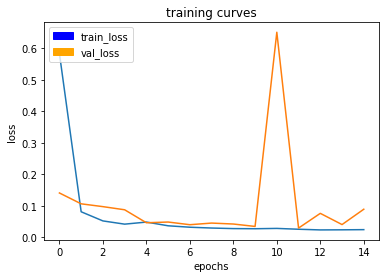

Epoch 00014: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0246 - val_loss: 0.0892
Epoch 16/200
129/130 [============================>.] - ETA: 0s - loss: 0.0226Epoch 00015: saving model to ../data/weights/history/18_01_2018_13_38_27/15-weights-val_loss(0.0483).h5


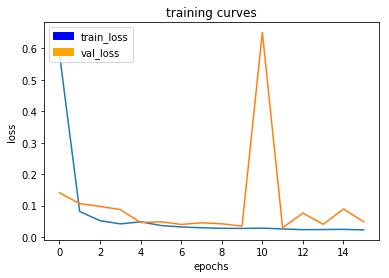

Epoch 00015: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0227 - val_loss: 0.0483
Epoch 17/200
129/130 [============================>.] - ETA: 0s - loss: 0.0218Epoch 00016: saving model to ../data/weights/history/18_01_2018_13_38_27/16-weights-val_loss(0.0353).h5


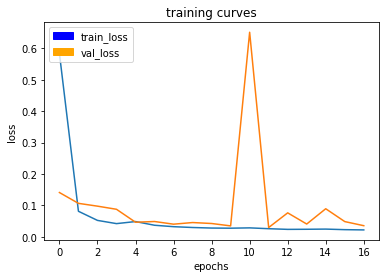

Epoch 00016: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0219 - val_loss: 0.0353
Epoch 18/200
129/130 [============================>.] - ETA: 0s - loss: 0.0204Epoch 00017: saving model to ../data/weights/history/18_01_2018_13_38_27/17-weights-val_loss(0.0383).h5


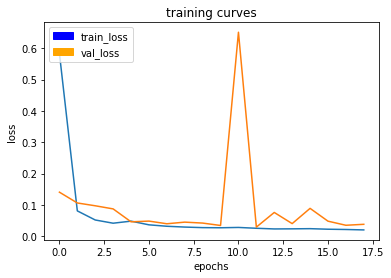

Epoch 00017: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0204 - val_loss: 0.0383
Epoch 19/200
129/130 [============================>.] - ETA: 0s - loss: 0.0193Epoch 00018: saving model to ../data/weights/history/18_01_2018_13_38_27/18-weights-val_loss(0.0210).h5


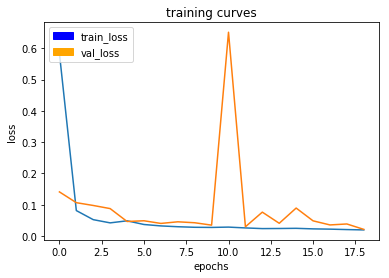

Epoch 00018: val_loss improved from 0.02943 to 0.02104, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0193 - val_loss: 0.0210
Epoch 20/200
129/130 [============================>.] - ETA: 0s - loss: 0.0191Epoch 00019: saving model to ../data/weights/history/18_01_2018_13_38_27/19-weights-val_loss(0.0383).h5


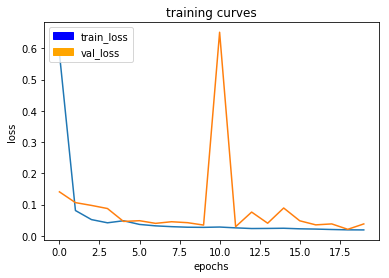

Epoch 00019: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0191 - val_loss: 0.0383
Epoch 21/200
129/130 [============================>.] - ETA: 0s - loss: 0.0184Epoch 00020: saving model to ../data/weights/history/18_01_2018_13_38_27/20-weights-val_loss(0.0378).h5


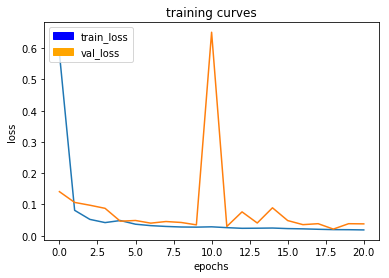

Epoch 00020: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0185 - val_loss: 0.0378
Epoch 22/200
129/130 [============================>.] - ETA: 0s - loss: 0.0187Epoch 00021: saving model to ../data/weights/history/18_01_2018_13_38_27/21-weights-val_loss(0.0437).h5


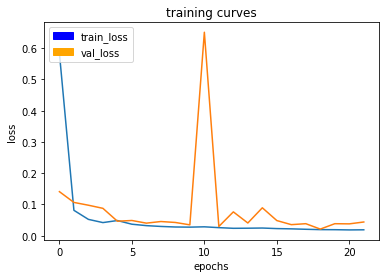

Epoch 00021: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0188 - val_loss: 0.0437
Epoch 23/200
129/130 [============================>.] - ETA: 0s - loss: 0.0184Epoch 00022: saving model to ../data/weights/history/18_01_2018_13_38_27/22-weights-val_loss(0.0308).h5


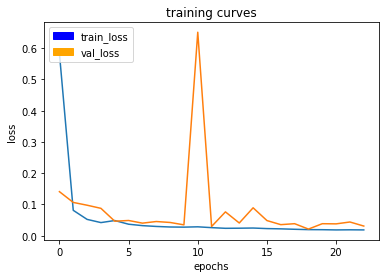

Epoch 00022: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0184 - val_loss: 0.0308
Epoch 24/200
129/130 [============================>.] - ETA: 0s - loss: 0.0207Epoch 00023: saving model to ../data/weights/history/18_01_2018_13_38_27/23-weights-val_loss(0.0938).h5


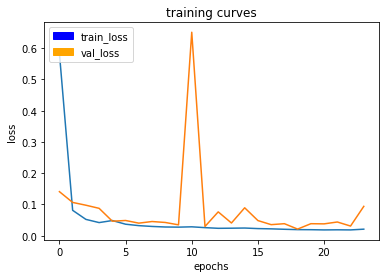

Epoch 00023: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0212 - val_loss: 0.0938
Epoch 25/200
129/130 [============================>.] - ETA: 0s - loss: 0.0231Epoch 00024: saving model to ../data/weights/history/18_01_2018_13_38_27/24-weights-val_loss(0.0405).h5


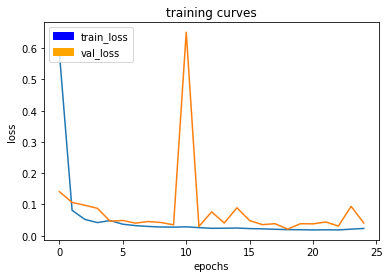

Epoch 00024: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0231 - val_loss: 0.0405
Epoch 26/200
129/130 [============================>.] - ETA: 0s - loss: 0.0181Epoch 00025: saving model to ../data/weights/history/18_01_2018_13_38_27/25-weights-val_loss(0.0451).h5


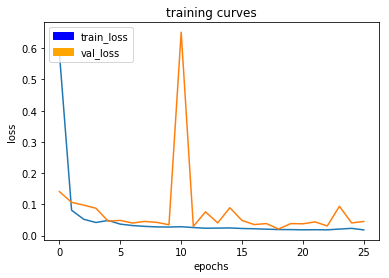

Epoch 00025: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0182 - val_loss: 0.0451
Epoch 27/200
129/130 [============================>.] - ETA: 0s - loss: 0.0187Epoch 00026: saving model to ../data/weights/history/18_01_2018_13_38_27/26-weights-val_loss(0.0839).h5


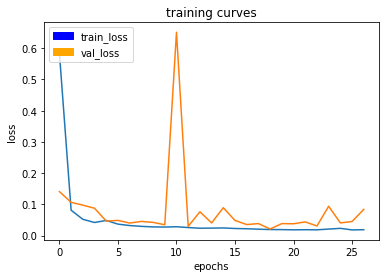

Epoch 00026: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0189 - val_loss: 0.0839
Epoch 28/200
129/130 [============================>.] - ETA: 0s - loss: 0.0229Epoch 00027: saving model to ../data/weights/history/18_01_2018_13_38_27/27-weights-val_loss(0.0483).h5


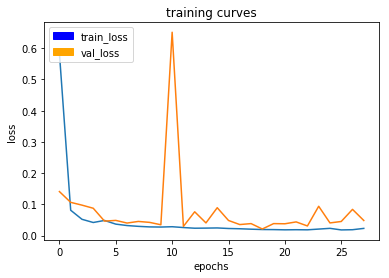

Epoch 00027: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0232 - val_loss: 0.0483
Epoch 29/200
129/130 [============================>.] - ETA: 0s - loss: 0.0202Epoch 00028: saving model to ../data/weights/history/18_01_2018_13_38_27/28-weights-val_loss(0.0360).h5


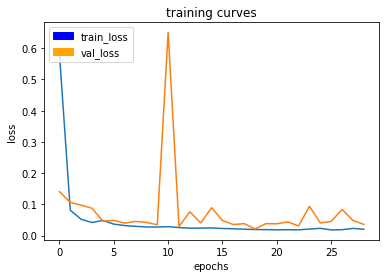

Epoch 00028: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0202 - val_loss: 0.0360
Epoch 30/200
129/130 [============================>.] - ETA: 0s - loss: 0.0178Epoch 00029: saving model to ../data/weights/history/18_01_2018_13_38_27/29-weights-val_loss(0.0324).h5


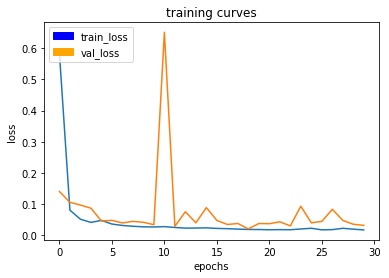

Epoch 00029: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0178 - val_loss: 0.0324
Epoch 31/200
129/130 [============================>.] - ETA: 0s - loss: 0.0168Epoch 00030: saving model to ../data/weights/history/18_01_2018_13_38_27/30-weights-val_loss(0.0364).h5


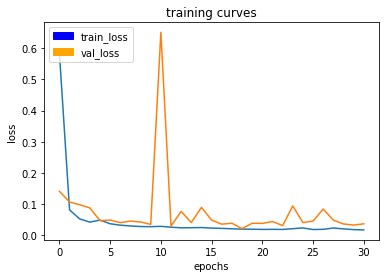

Epoch 00030: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0171 - val_loss: 0.0364
Epoch 32/200
129/130 [============================>.] - ETA: 0s - loss: 0.0172Epoch 00031: saving model to ../data/weights/history/18_01_2018_13_38_27/31-weights-val_loss(0.0469).h5


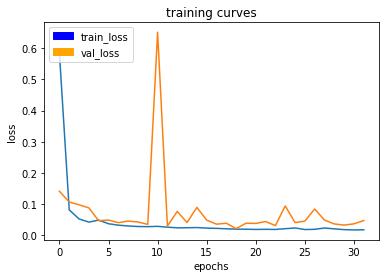

Epoch 00031: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0174 - val_loss: 0.0469
Epoch 33/200
129/130 [============================>.] - ETA: 0s - loss: 0.0176Epoch 00032: saving model to ../data/weights/history/18_01_2018_13_38_27/32-weights-val_loss(0.0463).h5


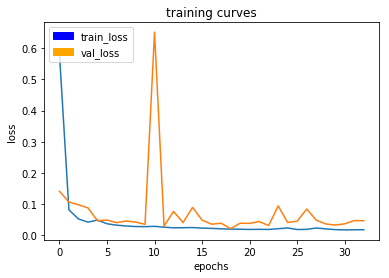

Epoch 00032: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0176 - val_loss: 0.0463
Epoch 34/200
129/130 [============================>.] - ETA: 0s - loss: 0.0164Epoch 00033: saving model to ../data/weights/history/18_01_2018_13_38_27/33-weights-val_loss(0.0168).h5


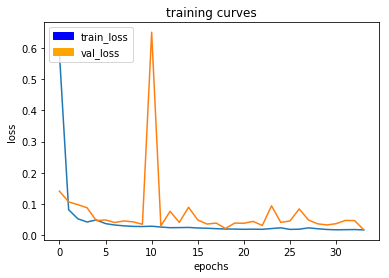

Epoch 00033: val_loss improved from 0.02104 to 0.01680, saving model to ../data/weights/weights.hd5
130/130 [==============================] - 62s - loss: 0.0164 - val_loss: 0.0168
Epoch 35/200
129/130 [============================>.] - ETA: 0s - loss: 0.0159Epoch 00034: saving model to ../data/weights/history/18_01_2018_13_38_27/34-weights-val_loss(0.0399).h5


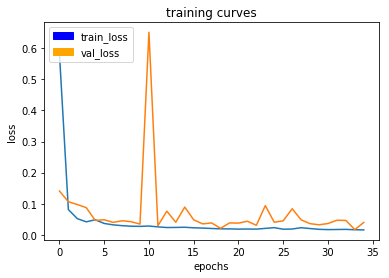

Epoch 00034: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0159 - val_loss: 0.0399
Epoch 36/200
129/130 [============================>.] - ETA: 0s - loss: 0.0182Epoch 00035: saving model to ../data/weights/history/18_01_2018_13_38_27/35-weights-val_loss(0.0297).h5


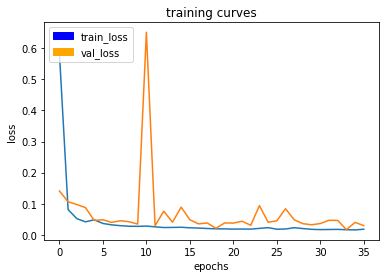

Epoch 00035: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0181 - val_loss: 0.0297
Epoch 37/200
129/130 [============================>.] - ETA: 0s - loss: 0.0154Epoch 00036: saving model to ../data/weights/history/18_01_2018_13_38_27/36-weights-val_loss(0.0266).h5


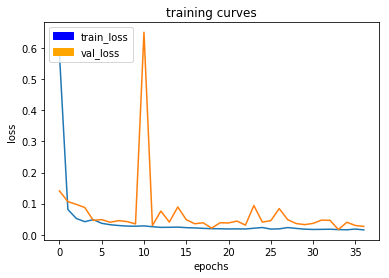

Epoch 00036: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0154 - val_loss: 0.0266
Epoch 38/200
129/130 [============================>.] - ETA: 0s - loss: 0.0150Epoch 00037: saving model to ../data/weights/history/18_01_2018_13_38_27/37-weights-val_loss(0.0394).h5


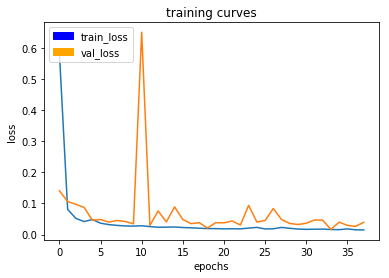

Epoch 00037: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0150 - val_loss: 0.0394
Epoch 39/200
129/130 [============================>.] - ETA: 0s - loss: 0.0146Epoch 00038: saving model to ../data/weights/history/18_01_2018_13_38_27/38-weights-val_loss(0.0234).h5


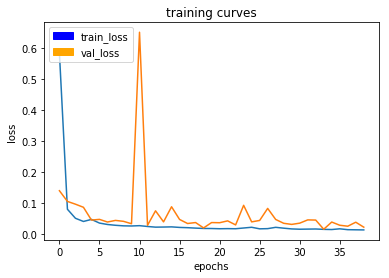

Epoch 00038: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0146 - val_loss: 0.0234
Epoch 40/200
129/130 [============================>.] - ETA: 0s - loss: 0.0142Epoch 00039: saving model to ../data/weights/history/18_01_2018_13_38_27/39-weights-val_loss(0.0305).h5


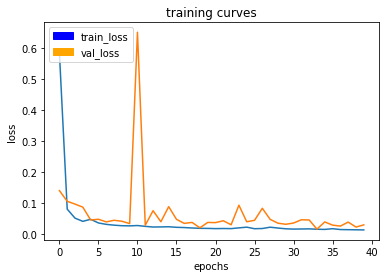

Epoch 00039: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0142 - val_loss: 0.0305
Epoch 41/200
129/130 [============================>.] - ETA: 0s - loss: 0.0141Epoch 00040: saving model to ../data/weights/history/18_01_2018_13_38_27/40-weights-val_loss(0.0408).h5


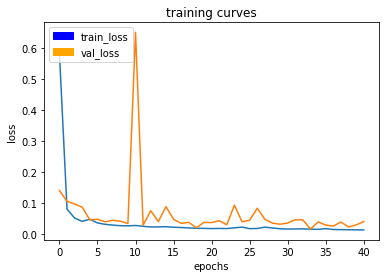

Epoch 00040: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0142 - val_loss: 0.0408
Epoch 42/200
129/130 [============================>.] - ETA: 0s - loss: 0.0145Epoch 00041: saving model to ../data/weights/history/18_01_2018_13_38_27/41-weights-val_loss(0.0254).h5


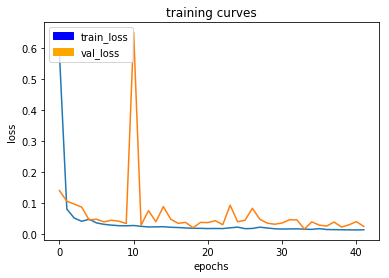

Epoch 00041: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0146 - val_loss: 0.0254
Epoch 43/200
129/130 [============================>.] - ETA: 0s - loss: 0.0142Epoch 00042: saving model to ../data/weights/history/18_01_2018_13_38_27/42-weights-val_loss(0.0333).h5


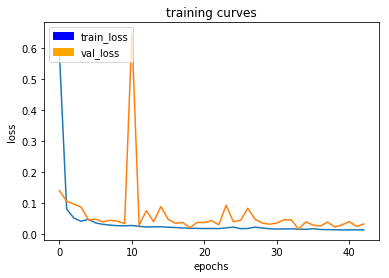

Epoch 00042: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0141 - val_loss: 0.0333
Epoch 44/200
129/130 [============================>.] - ETA: 0s - loss: 0.0137Epoch 00043: saving model to ../data/weights/history/18_01_2018_13_38_27/43-weights-val_loss(0.0406).h5


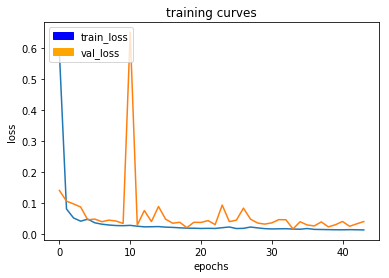

Epoch 00043: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0137 - val_loss: 0.0406
Epoch 45/200
129/130 [============================>.] - ETA: 0s - loss: 0.0139Epoch 00044: saving model to ../data/weights/history/18_01_2018_13_38_27/44-weights-val_loss(0.0514).h5


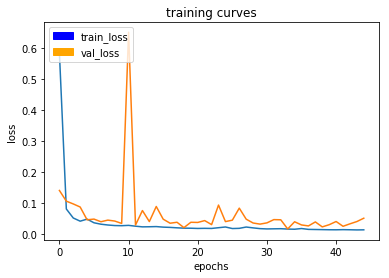

Epoch 00044: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0141 - val_loss: 0.0514
Epoch 46/200
129/130 [============================>.] - ETA: 0s - loss: 0.0151Epoch 00045: saving model to ../data/weights/history/18_01_2018_13_38_27/45-weights-val_loss(0.0263).h5


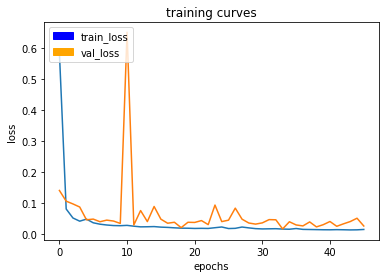

Epoch 00045: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0151 - val_loss: 0.0263
Epoch 47/200
129/130 [============================>.] - ETA: 0s - loss: 0.0145Epoch 00046: saving model to ../data/weights/history/18_01_2018_13_38_27/46-weights-val_loss(0.0317).h5


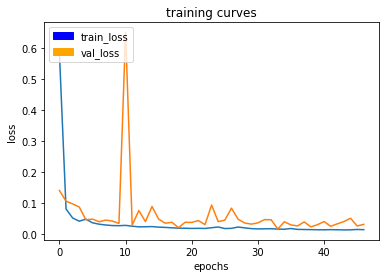

Epoch 00046: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0144 - val_loss: 0.0317
Epoch 48/200
129/130 [============================>.] - ETA: 0s - loss: 0.0140Epoch 00047: saving model to ../data/weights/history/18_01_2018_13_38_27/47-weights-val_loss(0.0933).h5


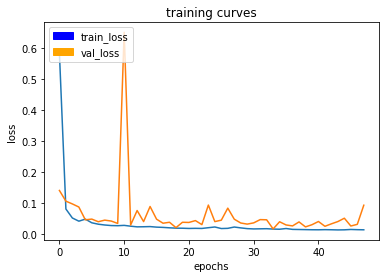

Epoch 00047: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0145 - val_loss: 0.0933
Epoch 49/200
129/130 [============================>.] - ETA: 0s - loss: 0.0206Epoch 00048: saving model to ../data/weights/history/18_01_2018_13_38_27/48-weights-val_loss(0.1150).h5


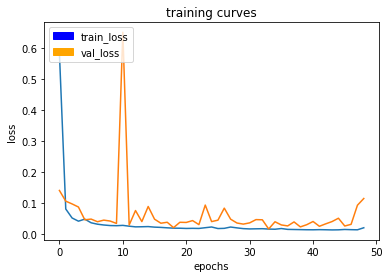

Epoch 00048: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0206 - val_loss: 0.1150
Epoch 50/200
129/130 [============================>.] - ETA: 0s - loss: 0.0159Epoch 00049: saving model to ../data/weights/history/18_01_2018_13_38_27/49-weights-val_loss(0.0435).h5


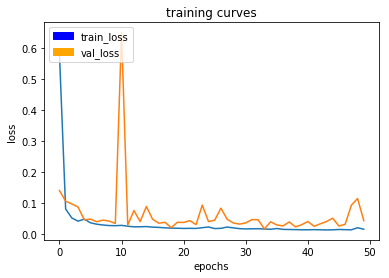

Epoch 00049: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0160 - val_loss: 0.0435
Epoch 51/200
129/130 [============================>.] - ETA: 0s - loss: 0.0168Epoch 00050: saving model to ../data/weights/history/18_01_2018_13_38_27/50-weights-val_loss(0.0292).h5


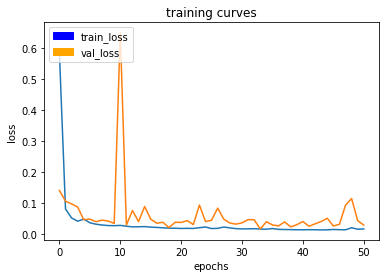

Epoch 00050: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0168 - val_loss: 0.0292
Epoch 52/200
129/130 [============================>.] - ETA: 0s - loss: 0.0194Epoch 00051: saving model to ../data/weights/history/18_01_2018_13_38_27/51-weights-val_loss(0.0300).h5


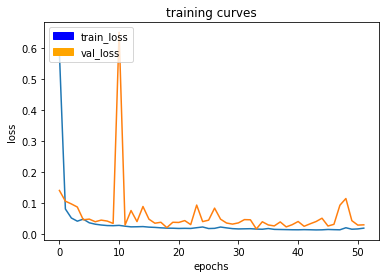

Epoch 00051: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0193 - val_loss: 0.0300
Epoch 53/200
129/130 [============================>.] - ETA: 0s - loss: 0.0161Epoch 00052: saving model to ../data/weights/history/18_01_2018_13_38_27/52-weights-val_loss(0.0403).h5


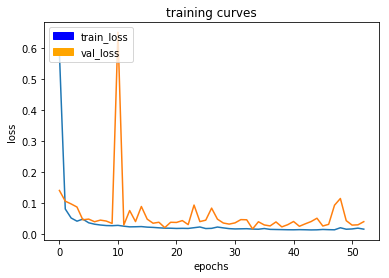

Epoch 00052: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0163 - val_loss: 0.0403
Epoch 54/200
129/130 [============================>.] - ETA: 0s - loss: 0.0164Epoch 00053: saving model to ../data/weights/history/18_01_2018_13_38_27/53-weights-val_loss(0.0212).h5


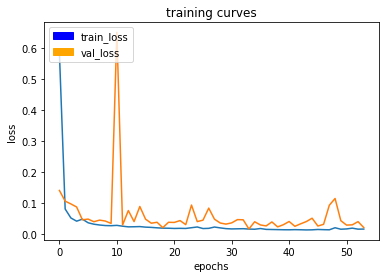

Epoch 00053: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0164 - val_loss: 0.0212
Epoch 55/200
129/130 [============================>.] - ETA: 0s - loss: 0.0141Epoch 00054: saving model to ../data/weights/history/18_01_2018_13_38_27/54-weights-val_loss(1.3411).h5


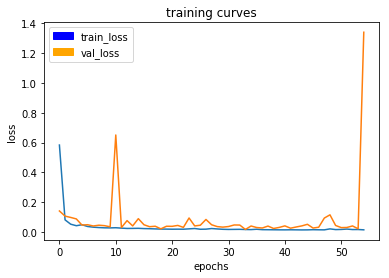

Epoch 00054: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0161 - val_loss: 1.3411
Epoch 56/200
129/130 [============================>.] - ETA: 0s - loss: 0.0355Epoch 00055: saving model to ../data/weights/history/18_01_2018_13_38_27/55-weights-val_loss(0.0299).h5


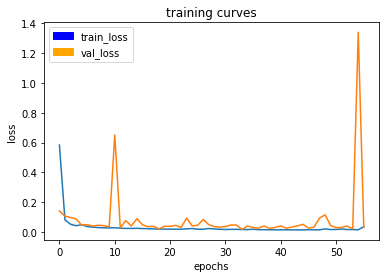

Epoch 00055: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0355 - val_loss: 0.0299
Epoch 57/200
129/130 [============================>.] - ETA: 0s - loss: 0.0200Epoch 00056: saving model to ../data/weights/history/18_01_2018_13_38_27/56-weights-val_loss(0.0320).h5


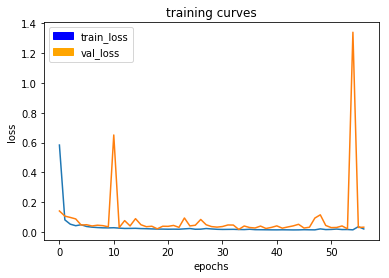

Epoch 00056: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0200 - val_loss: 0.0320
Epoch 58/200
129/130 [============================>.] - ETA: 0s - loss: 0.0165Epoch 00057: saving model to ../data/weights/history/18_01_2018_13_38_27/57-weights-val_loss(0.0182).h5


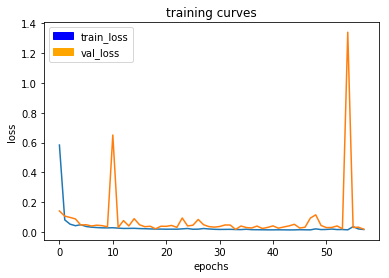

Epoch 00057: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0165 - val_loss: 0.0182
Epoch 59/200
129/130 [============================>.] - ETA: 0s - loss: 0.0153Epoch 00058: saving model to ../data/weights/history/18_01_2018_13_38_27/58-weights-val_loss(0.0510).h5


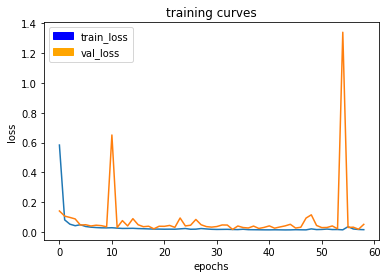

Epoch 00058: val_loss did not improve
130/130 [==============================] - 62s - loss: 0.0153 - val_loss: 0.0510
Epoch 60/200
129/130 [============================>.] - ETA: 0s - loss: 0.0146Epoch 00059: saving model to ../data/weights/history/18_01_2018_13_38_27/59-weights-val_loss(0.0224).h5


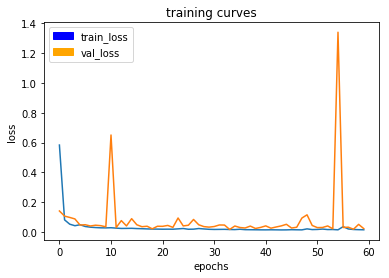

Epoch 00059: val_loss did not improve
130/130 [==============================] - 61s - loss: 0.0146 - val_loss: 0.0224
Epoch 00059: early stopping


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import json

sess = tf.Session()
writer = tf.summary.FileWriter('../logs')
writer.add_graph(sess.graph)

# Define the Keras model and compile it for training
arch_file_path = os.path.join("../data/weights/", T.arch_file_name)
weights_file_path = os.path.join("../data/weights/", T.weights_file_name)
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Nadam(T.learning_rate), loss='categorical_crossentropy') # lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
if T.reload_weights and os.path.isfile(weights_file_path):
    print ("Continuing training from existing model file:", arch_file_path)
    model.load_weights(weights_file_path)
else:
    print ("Building model from a clean slate...")

if not T.skip_training:
    ############################
    # Data iterators for loading the training and validation data
    ############################
    train_data_folders = []
    for name in T.train_set_names:
        train_data_folders.append(os.path.join('..', 'data', 'masks', 'train', name))
    print ("Training data: {}".format(train_data_folders))
    train_iter = data_iterator.BatchIteratorSimple(batch_size=T.batch_size,
                                                   data_folders=train_data_folders,
                                                   image_shape=T.image_shape,
                                                   shift_aug=True,
                                                   filter_callback = do_filter,
                                                   preprocess_callback = do_preprocess)
    validation_data_folders = []
    for name in T.validation_set_names:
        validation_data_folders.append(os.path.join('..', 'data', 'masks', 'validation', name))
    val_iter = data_iterator.BatchIteratorSimple(batch_size=T.batch_size,
                                                 data_folders=validation_data_folders,
                                                 image_shape=T.image_shape)

    # Setting up some callbacks
    callbacks = []
    callbacks.append(keras.callbacks.TensorBoard(log_dir='../logs'
#                                                  , histogram_freq=1, \
#                                                 write_graph=True, \
#                                                 write_grads=True, \
#                                                 batch_size=T.batch_size, \
#                                                 write_images=True)
                                                )
                    )
    callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=T.patience, verbose=1, mode='min'))

    ############################
    # History:
    ############################
    history_folder = os.path.join('../data/weights/history', time.strftime('%d_%m_%Y_%H_%M_%S'))
    if not os.path.exists(history_folder):
        os.makedirs(history_folder)

    # Hyperperamaters tracking for history
    with open(os.path.join(history_folder, "T.txt"), "w+") as T_file:
        T_file.write("{}".format(vars(T)))

    # Weights checkpoints for history
    callbacks.append(keras.callbacks.ModelCheckpoint(os.path.join(history_folder, '{epoch:02d}-weights-val_loss({val_loss:.4f}).h5'), 
                                                     monitor='val_loss', 
                                                     save_weights_only = True,
                                                     verbose=1, 
                                                     period=1))

    # Val_loss tracking and model architecture checkpoints for history:
    callbacks.append(plotting_tools.LoggerPlotter(model, 
                                                  arch_file_path=os.path.join(history_folder, T.arch_file_name),
                                                  image_path_template=os.path.join(history_folder, "{:02d}-val-loss-history-plot.png")))

    ############################
    # Optimal model tracking:
    ############################
    if not T.dry_run:
        callbacks.append(keras.callbacks.ModelCheckpoint(weights_file_path, 
                                                         monitor='val_loss', 
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         mode='auto',
                                                         verbose=1, 
                                                         period=1))

        # Also save the architecture
        model_arch_json = model.to_json()
        with open(arch_file_path, "w+") as arch_file:
            json.dump(model_arch_json, arch_file)

    ############################
    # Training:
    ############################
    model.fit_generator(train_iter,
                        steps_per_epoch = T.batches_per_epoch, # the number of batches per epoch,
                        epochs = T.num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = T.batches_per_validation, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = T.workers)

In [ ]:
# Save your trained model weights
# model_tools.save_network(model, T.weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
# model = model_tools.load_network(T.weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'
val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        'test', 'patrol_with_targ', run_num) 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        'test', 'patrol_non_targ', run_num) 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        'test', 'following_images', run_num)

# files being inferred: 322
	../data/masks/test/patrol_with_targ -> ../data/inferences/patrol_with_targ_run_1
# files being inferred: 270
	../data/masks/test/patrol_non_targ -> ../data/inferences/patrol_non_targ_run_1
# files being inferred: 542
	../data/masks/test/following_images -> ../data/inferences/following_images_run_1


Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

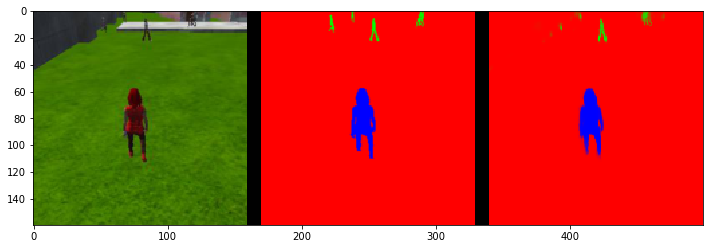

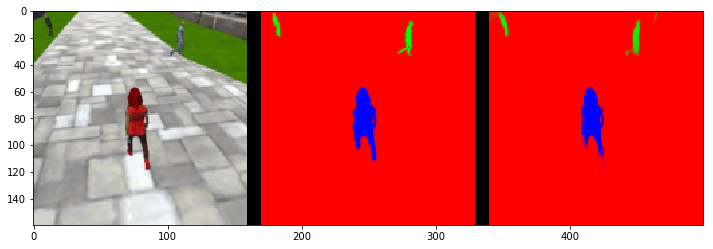

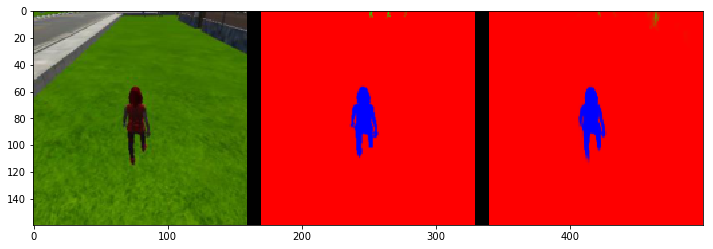

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('test', 'following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

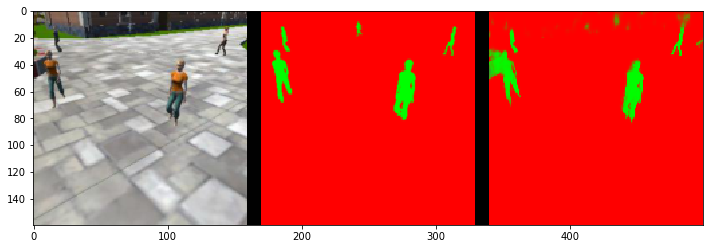

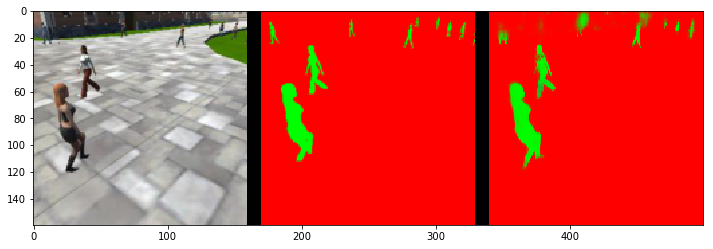

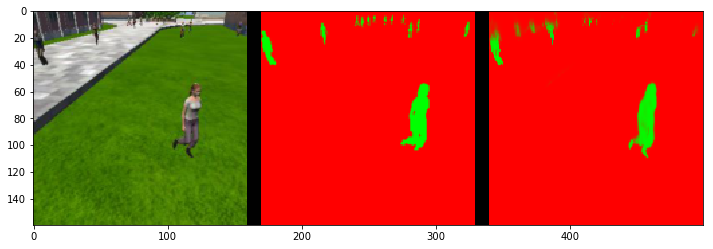

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('test', 'patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

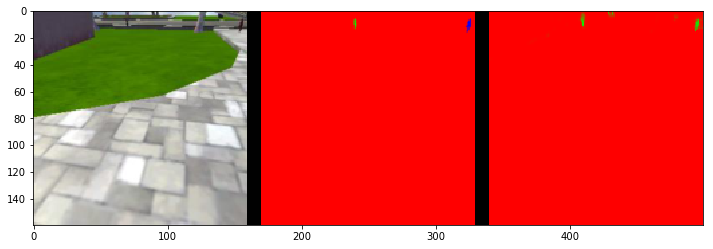

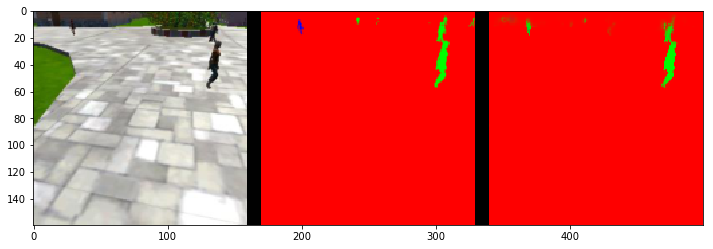

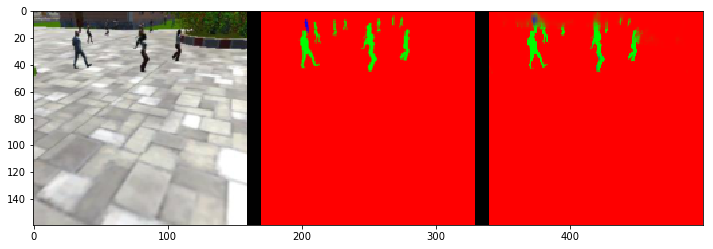

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('test', 'patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9950531828983175
average intersection over union for other people is 0.3445895070369044
average intersection over union for the hero is 0.8915988822713424
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9853840731856706
average intersection over union for other people is 0.7125949757865272
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 33, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959302498220088
average intersection over union for other people is 0.4284752370816154
average intersection over union for the hero is 0.17534525543298723
number true positives: 123, number false positives: 1, number false negatives: 178


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7574370709382151


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.533472068852


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.404071521259


In [24]:
# Now we will plot the graph created:
plotting_tools.plot_keras_model(model, "Graph")

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))